# System identification revisited

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', -1)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [44]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
ships

['M5064-02-A', 'wPCC']

In [5]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
ship_data = catalog.load(f"{ship}.ship_data")
thrust_keys = catalog.load(f"params:{ship}.thrust_keys")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)

[04/25/23 09:02:55] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=942642;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=67207;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[04/25/23 09:02:57] INFO     Kedro project phd                                                      ]8;id=223048;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=671996;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=125590;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=376850;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=694014;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=346585;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=438219;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=556211;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.thrust_keys' (MemoryDataSet)...     ]8;id=467750;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=894281;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=331659;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=882591;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=191054;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=817636;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [6]:
ship_data

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858,
 'scale_factor': 41.2,
 'x_r': -2.42219908951329,
 'TWIN': 1,
 'x_p': -2.42219908951329,
 'D': 0.12135922330097086,
 'w_p0': 0.151}

In [7]:
time_series_meta_data.head()

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test type,facility,angle1,angle2,scale_factor,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,xm,ym,zm,description
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22639,40199079,1,4,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\012\MDL-Proj40199079-Ser001-Test012-Run004.hdf5,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22638,40199079,1,3,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\012\MDL-Proj40199079-Ser001-Test012-Run003.hdf5,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22637,40199079,1,2,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\012\MDL-Proj40199079-Ser001-Test012-Run002.hdf5,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22636,40199079,1,1,12,M5139-02-A,M5139-02-A,167,NaN,0.641180,8.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\012\MDL-Proj40199079-Ser001-Test012-Run001.hdf5,2020-10-02,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.6 m/s
22634,40199079,1,4,10,M5139-02-A,M5139-02-A,167,NaN,0.801475,10.0 kn,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\010\MDL-Proj40199079-Ser001-Test010-Run004.hdf5,2020-10-06,reference speed,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,Reference speed 0.8 m/s


In [8]:
time_series_meta_data['test type'].unique()

array(['reference speed', 'sailing', 'turning circle', 'rodergrundvinkel',
       'zigzag'], dtype=object)

In [9]:
time_series_meta_data.groupby(by='test type').get_group('zigzag').head()

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test type,facility,angle1,angle2,scale_factor,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,xm,ym,zm,description
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22775,40199079,5,2,5,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 10/10PS,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\005\MDL-Proj40199079-Ser005-Test005-Run002.hdf5,2020-10-09,zigzag,MDL,NaN,NaN,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag
22762,40199079,5,1,1,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 10/10SB,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\001\MDL-Proj40199079-Ser005-Test001-Run001.hdf5,2020-09-23,zigzag,MDL,10.0,10.0,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag10/10
22765,40199079,5,1,2,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 10/10PS,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\002\MDL-Proj40199079-Ser005-Test002-Run001.hdf5,2020-09-23,zigzag,MDL,10.0,10.0,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag10/10
22763,40199079,5,2,1,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 10/10SB,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\001\MDL-Proj40199079-Ser005-Test001-Run002.hdf5,2020-09-24,zigzag,MDL,10.0,10.0,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag10/10
22764,40199079,5,3,1,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 10/10SB,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\001\MDL-Proj40199079-Ser005-Test001-Run003.hdf5,2020-09-24,zigzag,MDL,10.0,10.0,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag10/10


In [10]:
id = 22773
data_raw = time_series[str(id)]()

In [11]:
data_raw.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13.700013,0.0,1.0,2.146755,0.798334,0.104886,15.505859,2.567061,57.348541,0.8,2.146755,1.009509,0.163203,15.505859,3.341054,58.867588,0.010956,-0.002530,-0.000086,0.000233,-0.005931,0.001067,9.569964,5.505012,-0.115821,9.590799,5.687483,0.111180,-0.000007,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001138,0.000295,0.000087,7.164215,-0.000099,0.002467
13.710002,0.0,1.0,2.146755,0.798334,-0.143440,15.505859,1.447828,57.348541,0.8,2.146755,1.009509,0.084455,15.505859,4.807634,58.867588,0.001283,-0.003820,-0.007830,0.003454,-0.005931,0.009445,9.628717,5.555121,-0.116216,9.541293,5.671445,0.108954,-0.000014,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001158,-0.000311,0.000087,7.164259,-0.000180,0.002405
13.720003,0.0,1.0,2.146755,0.798334,-0.360041,15.505859,1.621502,57.348541,0.8,2.146755,1.009509,-0.049593,15.505859,-0.421882,58.867588,0.010311,0.001982,-0.007830,0.013117,-0.006576,-0.001511,9.603547,5.633792,-0.114932,9.556246,5.599838,0.105735,-0.000014,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001134,0.000372,0.000087,7.183286,-0.000100,0.002487
13.730005,0.0,1.0,2.146755,0.798334,-0.380839,15.505859,1.698691,57.348541,0.8,2.146755,1.009509,-0.133511,15.505859,5.367251,58.867588,-0.008389,-0.004464,-0.009121,0.000877,-0.005286,0.001711,9.572272,5.710973,-0.112320,9.540091,5.487629,0.102544,-0.000014,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001152,-0.000409,0.000087,7.183280,-0.000181,0.002469
13.740018,0.0,1.0,2.146755,0.798334,-0.173223,15.505859,2.084633,57.348541,0.8,2.146755,1.009509,-0.117504,15.505859,1.797285,58.867588,0.007087,0.006495,-0.009121,0.009252,-0.001418,-0.004733,9.564290,5.755025,-0.109036,9.560101,5.364202,0.100559,-0.000014,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001127,0.000531,0.000087,7.193513,-0.000101,0.002443


In [12]:
data = load(raw_data=data_raw)
data = add_thrust(data, thrust_channels=thrust_keys)

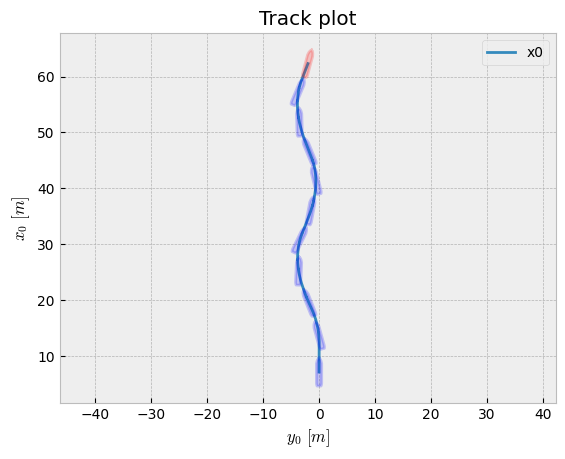

In [13]:
track_plot(df=data_raw, lpp=ship_data['L'], beam=ship_data['B']);

## Kalman filter system matrixes (-> f(...) and jacobi matrix)

In [14]:
system_matrixes = SystemMatrixes(vmm=vmm)

In [15]:
system_matrixes._lambda_f

<function _lambdifygenerated(Xu, Nu, psi, I_z, Xthrust, u, rho, thrust, Nvdot, Xudot, Yu, Nrdot, Nvvdelta, Nthrustdelta, Yur, Ydelta, Yr, v, Yv, Xvr, x_G, Yvvdelta, Ythrustdelta, Xrr, Nthrust, Nur, Xuu, L, r, delta, Xdeltadelta, Yrdot, Ndelta, Nr, Yvdot, m, Ythrust, Nv)>

In [16]:
system_matrixes._lambda_jacobian

<function _lambdifygenerated(Xu, Nu, psi, I_z, Xthrust, u, rho, thrust, Nvdot, Xudot, Yu, Nrdot, Nvvdelta, Nthrustdelta, Yur, Ydelta, Yr, v, Yv, Xvr, x_G, Yvvdelta, Ythrustdelta, Xrr, Nthrust, Nur, Xuu, L, r, delta, Xdeltadelta, Yrdot, Ndelta, Nr, Yvdot, h, m, Ythrust, Nv)>

## Brix initial guessed parameters

In [17]:
parameters = initial_parameters(ship_data=ship_data)

In [18]:
parameters

{'Xudot': 0.00017880704448812042,
 'Yvdot': -0.006109387408263365,
 'Yrdot': -0.00030313777458141895,
 'Nvdot': -0.00012825440172375716,
 'Nrdot': -0.00029867482773178765,
 'Xthrust': 1.0,
 'Ythrustdelta': 0.0,
 'Nthrustdelta': 0.0,
 'Xu': 0.0,
 'Xv': 0.0,
 'Xr': 0.0,
 'Xuu': 0.0,
 'Xvr': 0.0,
 'Xvdelta': 0.0,
 'Xrr': 0.0,
 'Xdeltadelta': 0.0,
 'Yu': 0.0,
 'Yv': -0.009712908347615236,
 'Yr': 0.0024023611364293648,
 'Ydelta': 0.003,
 'Yuv': 0.0,
 'Yur': 0.0,
 'Yvdeltadelta': 0.0,
 'Yrdeltadelta': 0.0,
 'Nu': 0.0,
 'Nv': -0.0031839517092233298,
 'Nr': -0.0017188512353564127,
 'Ndelta': -0.0015,
 'Nuv': 0.0,
 'Nur': 0.0,
 'Nvdeltadelta': 0.0,
 'Nrdeltadelta': 0.0}

## Extended Kalman Filter

In [19]:
ek = ExtendedKalman(
        vmm=vmm,
        parameters=parameters,
        ship_parameters=ship_data,
        system_matrixes=system_matrixes,
    )

In [20]:
x0 = initial_state(data)

In [21]:
ek_covariance_input = yaml.safe_load("""
process_variance:
  u : 0.003
  v : 0.003
  r : 0.019  # [deg]
measurement_error_max:
  positions: 0.05
  psi: 0.5  # [deg]
"""
)                                     
                                     
covariance_matrixes = guess_covariance_matrixes(ek_covariance_input=ek_covariance_input,data=data)

In [22]:
covariance_matrixes

{'P_prd': [[0.0002777777777777778, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 8.461594994075238e-06, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 3.0000001718705247e-05, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 3.0000001718705247e-05, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 3.31612576877064e-06]],
 'Qd': [[3.0000001718705247e-05, 0.0, 0.0],
  [0.0, 3.0000001718705247e-05, 0.0],
  [0.0, 0.0, 3.31612576877064e-06]],
 'Rd': [[0.0002777777777777778, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0],
  [0.0, 0.0, 8.461594994075238e-06]]}

## Filter states with initially guessed model

In [23]:
ek2, data_ek, time_steps = extended_kalman_filter(ek=ek, data=data, covariance_matrixes=covariance_matrixes, x0=x0, hydrodynamic_derivatives=parameters)
ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek2, data=data, time_steps=time_steps, covariance_matrixes=covariance_matrixes, hydrodynamic_derivatives=parameters)

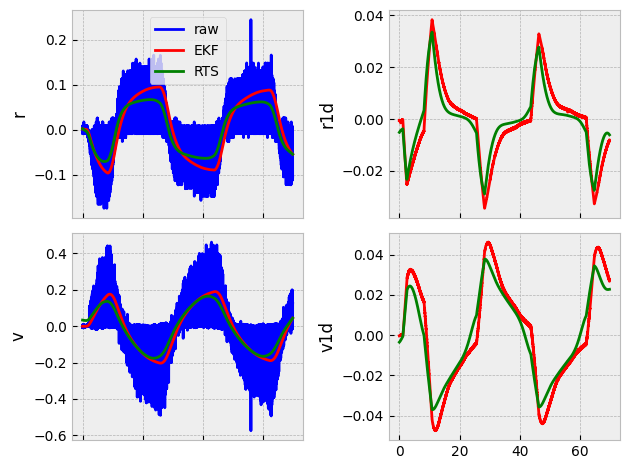

In [24]:
data_ = data.drop(columns=['v1d','r1d'])

dataframes = {
'raw':data_,
'EKF':data_ek,
'RTS':data_ek_smooth,
}
plot(dataframes=dataframes, keys=['v','r','v1d','r1d']);


## Inverse dynamics regression

In [25]:
added_masses = extract_added_masses(parameters=parameters)

In [26]:
data_with_force = predict_force(data=data_ek_smooth, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)
#data_with_force = predict_force(data=data_ek, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)

In [27]:
regression, derivatives = fit_motions(data=data_with_force, added_masses=added_masses, ship_data=ship_data, vmm=vmm, exclude_parameters=exclude_parameters)

In [28]:
derivatives

,regressed,$P_{value}$,$conf_{lower}$,$conf_{higher}$
Ndelta,-0.002159,0.000000e+00,-0.002185,-0.002132
Nr,-0.025001,5.197208e-187,-0.026630,-0.023372
Nthrustdelta,0.253875,9.502778e-184,0.237173,0.270577
Nu,-0.000011,6.117827e-95,-0.000012,-0.000010
Nur,0.023451,5.542911e-165,0.021817,0.025086
Nv,0.000579,1.889837e-89,0.000524,0.000635
Nvvdelta,-0.020077,0.000000e+00,-0.020889,-0.019264
Xdeltadelta,-0.003818,1.817889e-258,-0.004027,-0.003609
Xrr,-0.004193,1.743396e-62,-0.004681,-0.003706
Xu,-0.043381,6.094591e-113,-0.047077,-0.039684


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fx   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          2.936e+04
Date:                Tue, 25 Apr 2023   Prob (F-statistic):                        0.00
Time:                        09:03:13   Log-Likelihood:                          48189.
No. Observations:                6983   AIC:                                 -9.637e+04
Df Residuals:                    6978   BIC:                                 -9.633e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Xdeltadelta    -0.0038      0.000    -35.848      0.000      -0.004      -0.004
Xvr            -0.0123      0.001    -16.023      0.000      -0.014      -0.011
Xrr            -0.0042      0.000    -16.851      0.000      -0.005      -0.004
Xuu             0.0430      0.002     22.751      0.000       0.039       0.047
Xu             -0.0434      0.002    -23.005      0.000      -0.047      -0.040
==============================================================================
Omnibus:                     3989.533   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33928.282
Skew:                           2.666   Prob(JB):                         0.00
Kurtosis:                      12.390   Cond. No.                     1.34e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fy   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          7.443e+04
Date:                Tue, 25 Apr 2023   Prob (F-statistic):                        0.00
Time:                        09:03:13   Log-Likelihood:                          43766.
No. Observations:                6983   AIC:                                 -8.752e+04
Df Residuals:                    6979   BIC:                                 -8.750e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yur           -0.0619      0.003    -19.208      0.000      -0.068      -0.056
Yr             0.0622      0.003     19.340      0.000       0.056       0.068
Yu         -7.967e-05   5.66e-06    -14.076      0.000   -9.08e-05   -6.86e-05
Yv            -0.0187      0.000   -151.613      0.000      -0.019      -0.018
==============================================================================
Omnibus:                      658.598   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.944
Skew:                           0.076   Prob(JB):                     8.53e-45
Kurtosis:                       2.179   Cond. No.                         821.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mz   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          5.961e+04
Date:                Tue, 25 Apr 2023   Prob (F-statistic):                        0.00
Time:                        09:03:13   Log-Likelihood:                          60592.
No. Observations:                6983   AIC:                                 -1.212e+05
Df Residuals:                    6976   BIC:                                 -1.211e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Nvvdelta        -0.0201      0.000    -48.444      0.000      -0.021      -0.019
Nu            -1.07e-05    5.1e-07    -20.994      0.000   -1.17e-05    -9.7e-06
Ndelta          -0.0022   1.33e-05   -161.978      0.000      -0.002      -0.002
Nthrustdelta     0.2539      0.009     29.797      0.000       0.237       0.271
Nr              -0.0250      0.001    -30.080      0.000      -0.027      -0.023
Nur              0.0235      0.001     28.127      0.000       0.022       0.025
Nv               0.0006   2.85e-05     20.347      0.000       0.001       0.001
==============================================================================
Omnibus:                      364.527   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              655.104
Skew:                          -0.405   Prob(JB):                    5.57e-143
Kurtosis:                       4.263   Cond. No.                     1.71e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

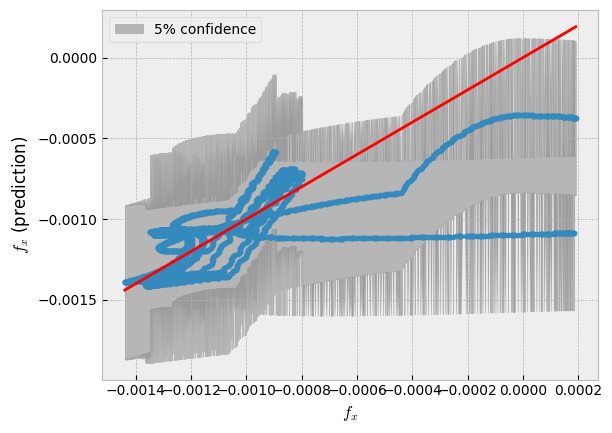

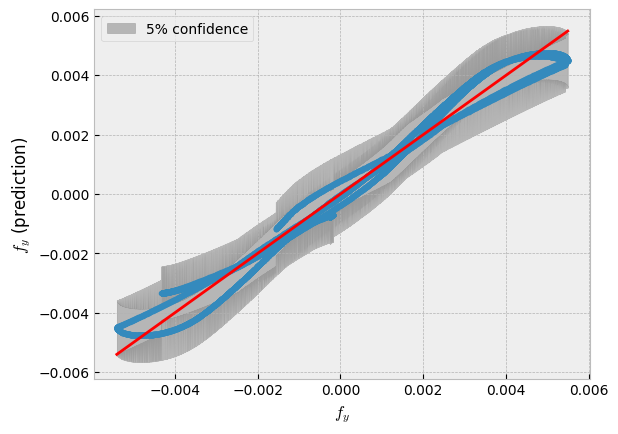

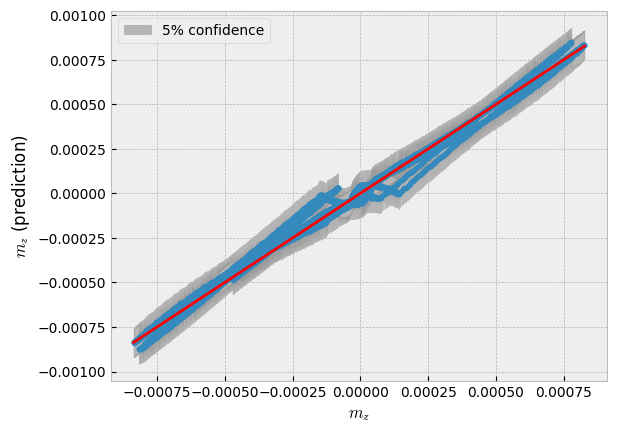

In [29]:
regression.show()

In [30]:
model = create_model_from_motion_regression(regression=regression)

In [31]:
#model.simulate(data_ek_smooth)

In [32]:
data_simulated = simulate_euler(data=data_ek_smooth, model=model, ek=ek)

In [33]:
model_guess = model.copy()
model_guess.parameters = {key:parameters.get(key,0) for key in model.parameters.keys()}
data_simulated_guess = simulate_euler(data=data_ek_smooth, model=model_guess, ek=ek)

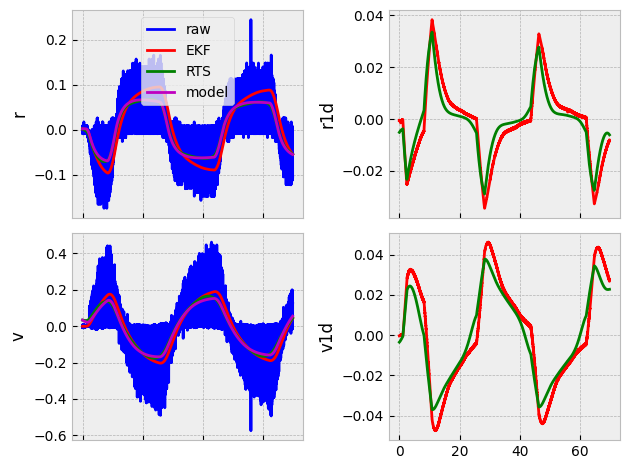

In [34]:
data_ = data.drop(columns=['v1d','r1d'])

dataframes = {
'raw':data_,
'EKF':data_ek,
'RTS':data_ek_smooth,
'model':data_simulated,
}
plot(dataframes=dataframes, keys=['v','r','v1d','r1d']);

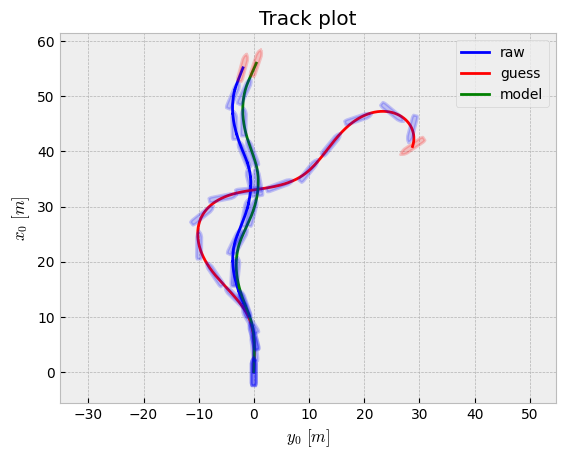

In [35]:

dataframes = {
'raw':data,
'guess':data_simulated_guess,
'model':data_simulated,
}
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B']);

In [36]:
covariance_matrixes

{'P_prd': [[0.0002777777777777778, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 8.461594994075238e-06, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 3.0000001718705247e-05, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 3.0000001718705247e-05, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 3.31612576877064e-06]],
 'Qd': [[3.0000001718705247e-05, 0.0, 0.0],
  [0.0, 3.0000001718705247e-05, 0.0],
  [0.0, 0.0, 3.31612576877064e-06]],
 'Rd': [[0.0002777777777777778, 0.0, 0.0],
  [0.0, 0.0002777777777777778, 0.0],
  [0.0, 0.0, 8.461594994075238e-06]]}

In [37]:
itterations = []
derivatives = parameters.copy()
covariance_matrixes_itterations = covariance_matrixes.copy()

for i in range(0,5):
    
    ek2, data_ek, time_steps = extended_kalman_filter(ek=ek, data=data, covariance_matrixes=covariance_matrixes_itterations, x0=x0, hydrodynamic_derivatives=derivatives)
    ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek2, data=data, time_steps=time_steps, covariance_matrixes=covariance_matrixes_itterations, hydrodynamic_derivatives=derivatives)
    data_with_force = predict_force(data=data_ek_smooth, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)
    regression, derivatives = fit_motions(data=data_with_force, added_masses=added_masses, ship_data=ship_data, vmm=vmm, exclude_parameters=exclude_parameters)
    model = create_model_from_motion_regression(regression=regression)
    data_simulated = simulate_euler(data=data_ek_smooth, model=model, ek=ek_smooth)
    
    covariance_matrixes_itterations['Qd'] = np.array(covariance_matrixes_itterations['Qd'])*0.7
    
    itterations.append(
        {
            'data_ek':data_ek,
            'data_ek_smooth':data_ek_smooth,
            'derivatives':derivatives,
            'data_simulated':data_simulated,
        }
    )

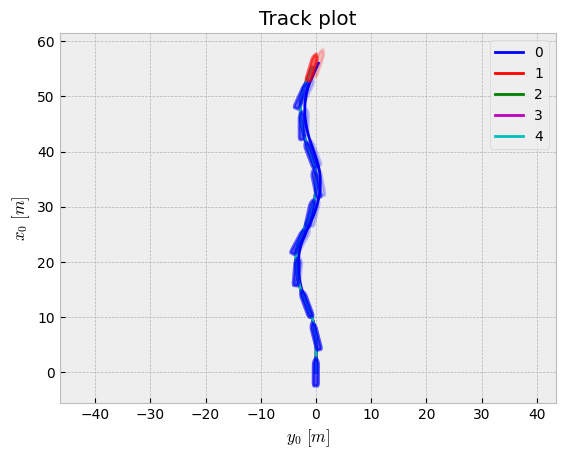

In [38]:
track_plots(dataframes={str(i):itteration['data_simulated'] for i,itteration in enumerate(itterations)}, lpp=ship_data['L'], beam=ship_data['B']);

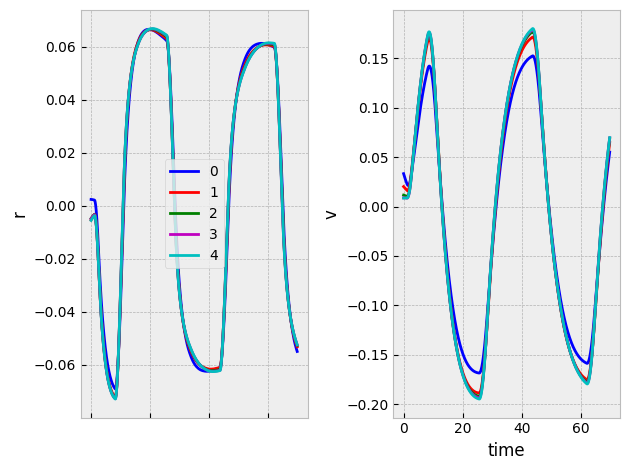

In [39]:
plot(dataframes={str(i):itteration['data_simulated'] for i,itteration in enumerate(itterations)}, keys=['v','r']);

In [40]:
df_MSE = pd.DataFrame()
for dof in ['u','v','r']:
    df_MSE[dof] = pd.Series({i:mean_squared_error(y_true = data[dof], y_pred=itteration['data_simulated'][dof]) for i,itteration in enumerate(itterations)}, name=dof)

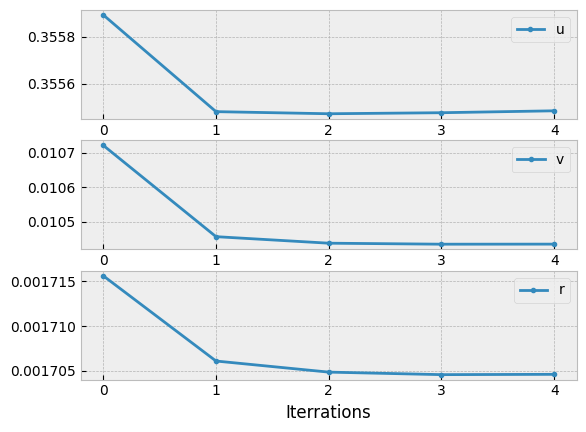

In [41]:
fig,axess =plt.subplots(nrows=3)
for ax,dof in zip(axess,['u','v','r']):
    df_MSE.plot(y=dof, style='.-', ax=ax)
    ax.set_xticks(df_MSE.index)
ax.set_xlabel('Iterrations');


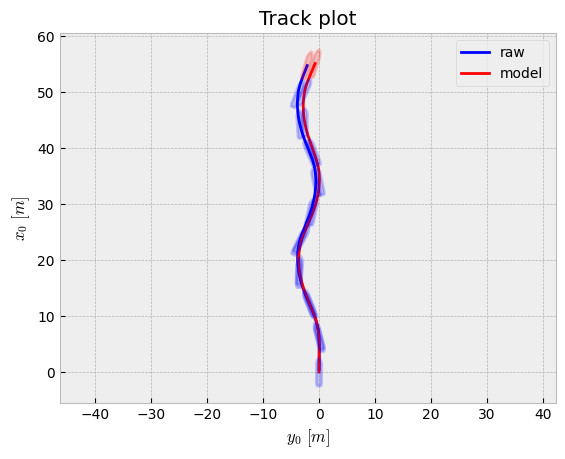

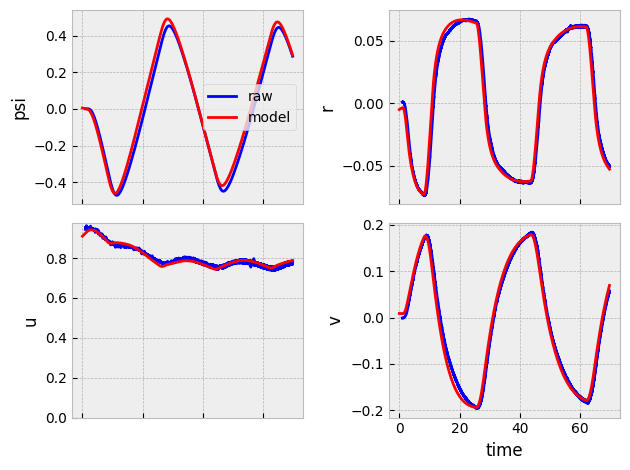

In [43]:
dataframes = {
'raw':data.rolling(100).mean(),
#'guess':data_simulated_guess,
'model':itterations[3]['data_simulated'] ,
}
track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B']);
plot(dataframes, keys=['u','v','r','psi']);